In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sys

plt.style.use("../matplotlib_style/standard_plot_style.mplstyle")

import qutip

save_figures = True
save_path    = "/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/Figs/Results/readout_strategies/experimental"

sys.path.append("../utils")


In [3]:
data = pd.read_csv("/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/kode/experiments/trace_data/trace_2k_10us_10ns_resolution.csv")
dt   = 10
data

,trajectory,initial_state,I,Q,t
0,0,0,0.088654,-0.083207,0
1,0,0,-0.016861,0.007177,10
2,0,0,0.008373,-0.075257,20
3,0,0,0.091618,0.108743,30
4,0,0,-0.070568,0.067275,40
...,...,...,...,...,...
1051995,1999,1,0.031231,0.047182,5210
1051996,1999,1,0.021475,0.065333,5220
1051997,1999,1,0.021907,0.037958,5230
1051998,1999,1,-0.025766,-0.142284,5240


# Data Visuialization and Baseline Prediction

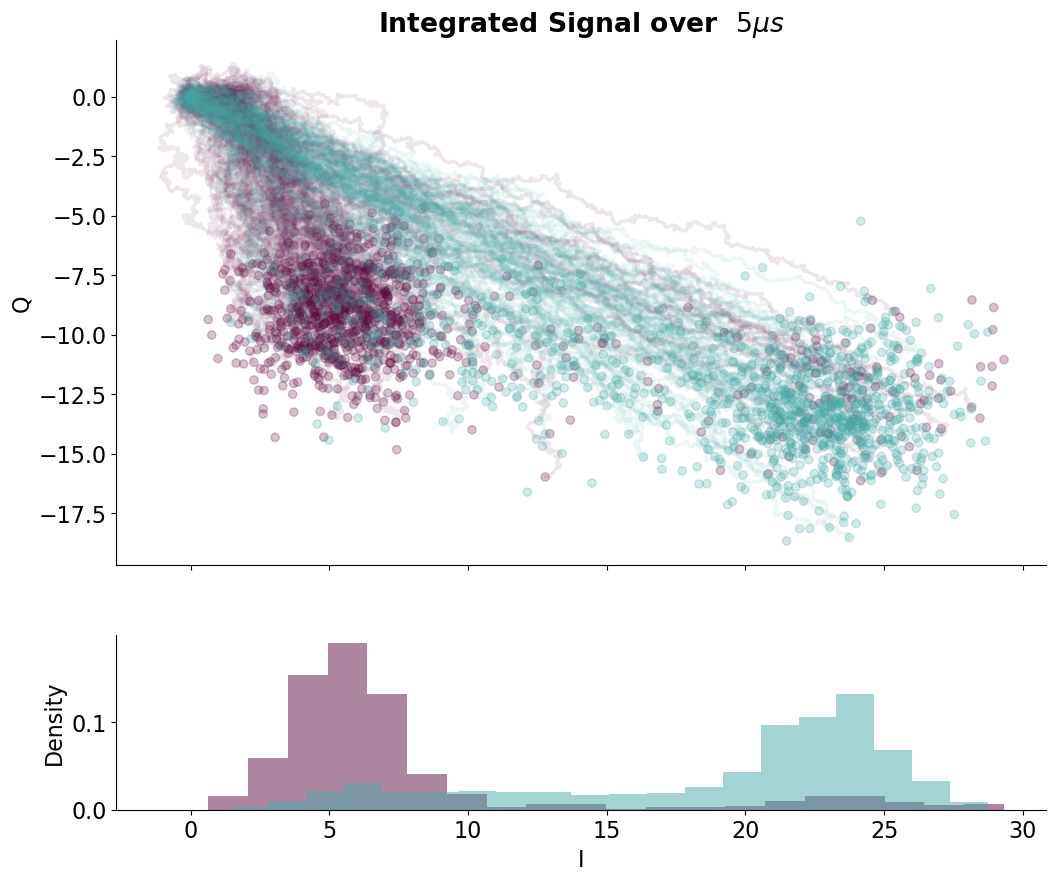

In [4]:
count = 100
fig, ax = plt.subplots(figsize = (12, 10), nrows = 2, gridspec_kw = {"height_ratios": [3, 1]}, sharex = True)

# Just the most simple summing of the data
cumulative_summed = data[np.logical_or(data.trajectory < count, data.trajectory > data.trajectory.max() - count)].groupby("trajectory").apply(lambda x: x.assign(I = x.I.cumsum(), Q = x.Q.cumsum()))
cumulative_summed.initial_state = cumulative_summed.initial_state > 0 
color  = cumulative_summed.groupby("trajectory").initial_state.first().apply(lambda x: "C1" if x else "C0")
for traj in cumulative_summed.trajectory.unique():
    ax[0].plot(cumulative_summed.I[cumulative_summed.trajectory == traj], cumulative_summed.Q[cumulative_summed.trajectory == traj], c = color[traj], alpha = 0.1)

# Complete sum
summed = data.groupby("trajectory").agg({"I": "sum", "Q": "sum", "initial_state": "first"})
summed.initial_state = summed.initial_state > 0
color  = summed.initial_state.apply(lambda x: "C1" if x else "C0")

ax[0].scatter(summed.I, summed.Q, c = color, alpha = 0.25)

ax[1].hist(summed.I[summed.initial_state == 0], bins = 20, alpha = 0.5, label = "0", density = True)
ax[1].hist(summed.I[summed.initial_state >= 1], bins = 20, alpha = 0.5, label = "1", density = True);

ax[0].set(
    title = "Integrated Signal over  $5 \mu s$",
    ylabel = "Q"
)

ax[1].set(
    xlabel = "I",
    ylabel = "Density"
)

fig.savefig(save_path + "/Integrated_signal.png", dpi = 300)

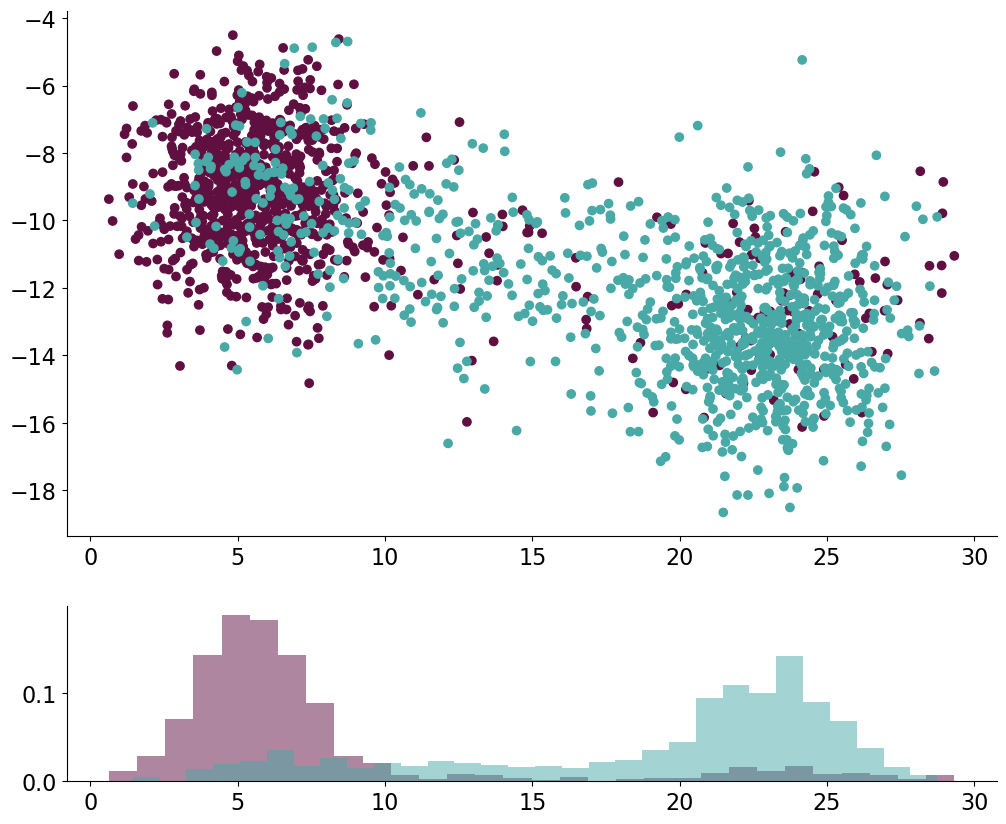

In [5]:
fig, ax = plt.subplots(figsize = (12, 10), nrows = 2, gridspec_kw = {"height_ratios": [3, 1]})

# Just the most simple summing of the data
summed = data.groupby("trajectory").aggregate("sum")
summed.initial_state = summed.initial_state > 0 
color  = summed.initial_state.apply(lambda x: "C0" if x == 0 else "C1")


ax[0].scatter(summed.I, summed.Q, c = color)

ax[1].hist(summed.I[summed.initial_state == 0], bins = 30, alpha = 0.5, label = "0", density = True)
ax[1].hist(summed.I[summed.initial_state >= 1], bins = 30, alpha = 0.5, label = "1", density = True);

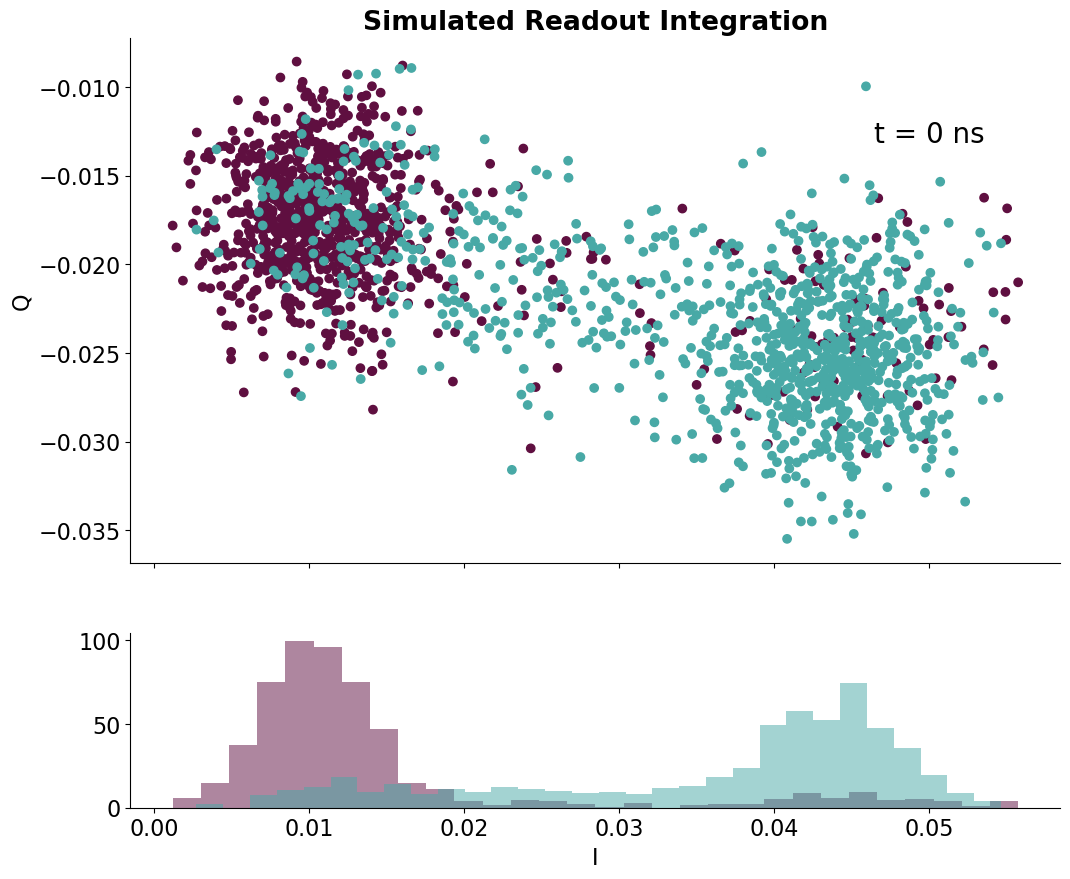

In [6]:
# The same but animated
fig, ax = plt.subplots(figsize = (12, 10), nrows = 2, gridspec_kw = {"height_ratios": [3, 1]}, sharex = True)

summed = data.groupby("trajectory").aggregate("mean")
summed.initial_state = summed.initial_state > 0 
color  = summed.initial_state.apply(lambda x: "C0" if x == 0 else "C1")

scat = ax[0].scatter(summed.I, summed.Q, c = color)

ax[0].set(
    title = "Simulated Readout Integration",
    ylabel = "Q"
)
ax[1].set(
    xlabel = "I"
)

ax[0].text(0.8, 0.8, f"t = 0 ns", transform = ax[0].transAxes, fontsize = 20)

ax[1].hist(summed.I[summed.initial_state == 0], bins = 30, alpha = 0.5, label = "0", density = True)
ax[1].hist(summed.I[summed.initial_state >= 1], bins = 30, alpha = 0.5, label = "1", density = True);

# ax[1].set_xlim(-2, 2)
# ax[0].set_ylim

def update(frame):
    ax[0].cla()
    ax[1].cla()

    ax[0].set(
        title = "Simulated Readout Integration",
        ylabel = "Q"
    )
    ax[1].set(
        xlabel = "I",
        ylabel = "Density"
    )



    ax[0].text(0.8, 0.8, f"t = {frame} ns", transform = ax[0].transAxes, fontsize = 20)

    ax[1].set_xlim(-0.1, 0.2)
    ax[0].set_ylim(-1.25, 0.25)

    summed = data[data.t < frame].groupby("trajectory").aggregate("mean")
    summed.initial_state = summed.initial_state > 0 
    color  = summed.initial_state.apply(lambda x: "C0" if x == 0 else "C1")

    scat = ax[0].scatter(summed.I, summed.Q, c = color)

    ax[1].hist(summed.I[summed.initial_state == 0], bins = 30, alpha = 0.5, label = "0", density = True)
    ax[1].hist(summed.I[summed.initial_state >= 1], bins = 30, alpha = 0.5, label = "1", density = True);



In [7]:
from IPython.display import HTML 
if False:
    from matplotlib.animation import FuncAnimation
    anim = FuncAnimation(fig, update, frames = np.arange(100, 5100, 25), interval = 1000 / 30)
    anim.save(save_path + "/stochastic_measurements.mp4", writer = "ffmpeg", fps = 30)
    # display(HTML(anim.to_html5_video()))

Text(0.5, 1.0, 'ROC when summing (unweighted) I only')

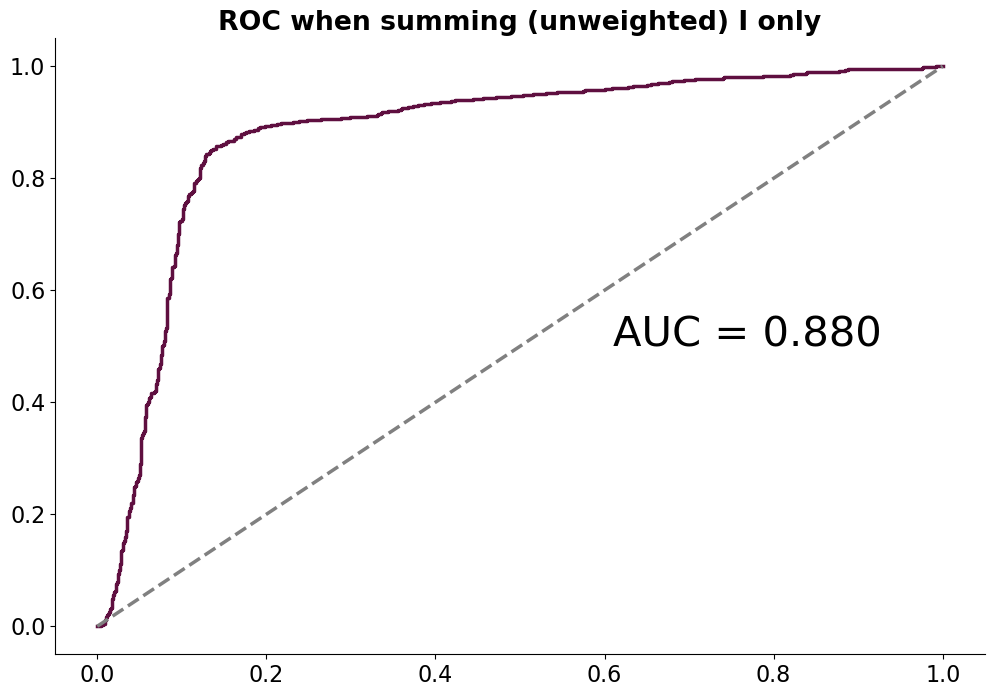

In [8]:
fig, ax = plt.subplots()

from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, _ = roc_curve(summed.initial_state, summed.I)

ax.plot(fpr, tpr, label = "ROC (I)")
ax.plot([0, 1], [0, 1], "--", label = "Random", color = "gray")
ax.text(0.60, 0.50, f"AUC = {roc_auc_score(summed.initial_state, summed.I):.3f}", transform = ax.transAxes, fontsize = 30)
ax.set_title("ROC when summing (unweighted) I only")

Text(0.5, 1.0, 'ROC when summing (unweighted) I & Q - LDA ')

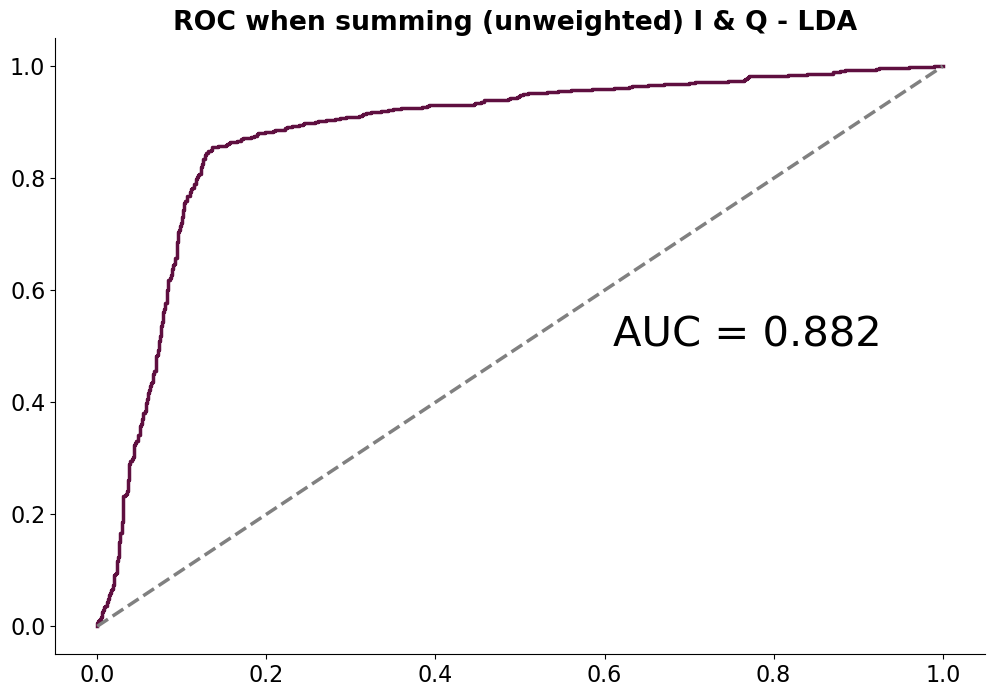

In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA 

lda = LDA()
transformed = lda.fit_transform(summed[["I", "Q"]], summed.initial_state)

fig, ax = plt.subplots()

fpr, tpr, _ = roc_curve(summed.initial_state, transformed)

ax.plot(fpr, tpr, label = "ROC (I)")
ax.plot([0, 1], [0, 1], "--", label = "Random", color = "gray")
ax.text(0.60, 0.50, f"AUC = {roc_auc_score(summed.initial_state, transformed):.3f}", transform = ax.transAxes, fontsize = 30)
ax.set_title("ROC when summing (unweighted) I & Q - LDA ")


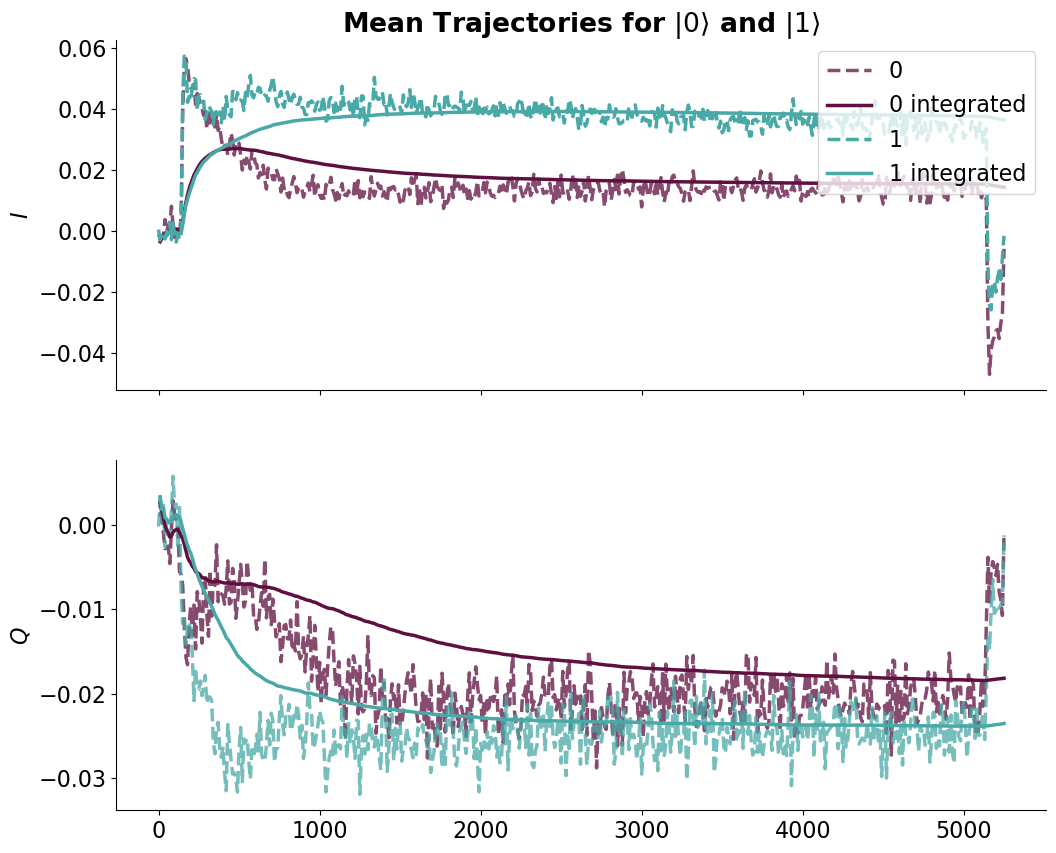

In [10]:
fig, ax = plt.subplots(nrows = 2, figsize = (12, 10), gridspec_kw = {"height_ratios": [1, 1]}, sharex = True)

data0 = data[data.initial_state == 0]
data1 = data[data.initial_state == 1]

I_mean_0 = data0.groupby("t").I.agg("mean")
I_mean_1 = data1.groupby("t").I.agg("mean")

I_mean_0_integrated = I_mean_0.cumsum() / I_mean_0.index * dt 
I_mean_1_integrated = I_mean_1.cumsum() / I_mean_1.index * dt

I_std_0  = data0.groupby("t").I.agg("std")
I_std_1  = data1.groupby("t").I.agg("std")

Q_mean_0 = data0.groupby("t").Q.agg("mean")
Q_mean_1 = data1.groupby("t").Q.agg("mean")

Q_mean_0_integrated = Q_mean_0.cumsum() / Q_mean_0.index * dt 
Q_mean_1_integrated = Q_mean_1.cumsum() / Q_mean_1.index * dt

Q_std_0  = data0.groupby("t").Q.agg("std")
Q_std_1  = data1.groupby("t").Q.agg("std")

ax[0].set_title(r"Mean Trajectories for $|0\rangle$ and $|1\rangle$")
ax[0].plot(I_mean_0, "--", alpha = 0.75, label = "0")
ax[0].plot(I_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")

# ax[0].fill_between(I_mean_0.index, I_mean_0 - I_std_0 / np.sqrt(1000), I_mean_0 + I_std_0 / np.sqrt(1000), alpha = 0.25, color = "C0")
# ax[0].fill_between(I_mean_1.index, I_mean_1 - I_std_1 / np.sqrt(1000), I_mean_1 + I_std_1 / np.sqrt(1000), alpha = 0.25, color = "C1")

ax[0].plot(I_mean_1, "--", alpha = 1, label = "1")
ax[0].plot(I_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[0].set_ylabel(r"$I$")


ax[1].plot(Q_mean_0, "--", alpha = .75, label = "0", color = "C0")
ax[1].plot(Q_mean_1, "--", alpha = .75, label = "1", color = "C1")

ax[1].plot(Q_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")
ax[1].plot(Q_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

# ax[1].fill_between(Q_mean_0.index, Q_mean_0 - Q_std_0 / 8, Q_mean_0 + Q_std_0 / 8, alpha = 0.25, color = "C0")
# ax[1].fill_between(Q_mean_1.index, Q_mean_1 - Q_std_1 / 8, Q_mean_1 + Q_std_1 / 8, alpha = 0.25, color = "C1")

ax[1].set_ylabel(r"$Q$")

ax[0].legend(loc = "upper right")

fig.savefig(save_path + "/mean_trajectories.png", dpi = 300)


## Performance as a function of integration time

In [10]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [11]:
included_times = np.arange(100, 5050, 100)
auc_scores     = []
fidelity_scores = []

for time in tqdm(included_times):
    Q_val = data.groupby("trajectory").apply(lambda x: x.I[x.t < time].mean())
    I_val = data.groupby("trajectory").apply(lambda x: x.Q[x.t < time].mean())

    lda = LDA()
    transformed = lda.fit_transform(np.array([Q_val, I_val]).T, summed.initial_state)

    confusion = confusion_matrix(summed.initial_state, transformed > 0, normalize = "true")
    fidelity_scores.append(1 - (confusion[0, 1] + confusion[1, 0]))

    auc = roc_auc_score(summed.initial_state, transformed)

    auc_scores.append(auc)

auc_scores = np.array(auc_scores)
fidelity_scores = np.array(fidelity_scores)


100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


Text(0.15, 0.1, 'Time of max AUC score = 1700 ns')

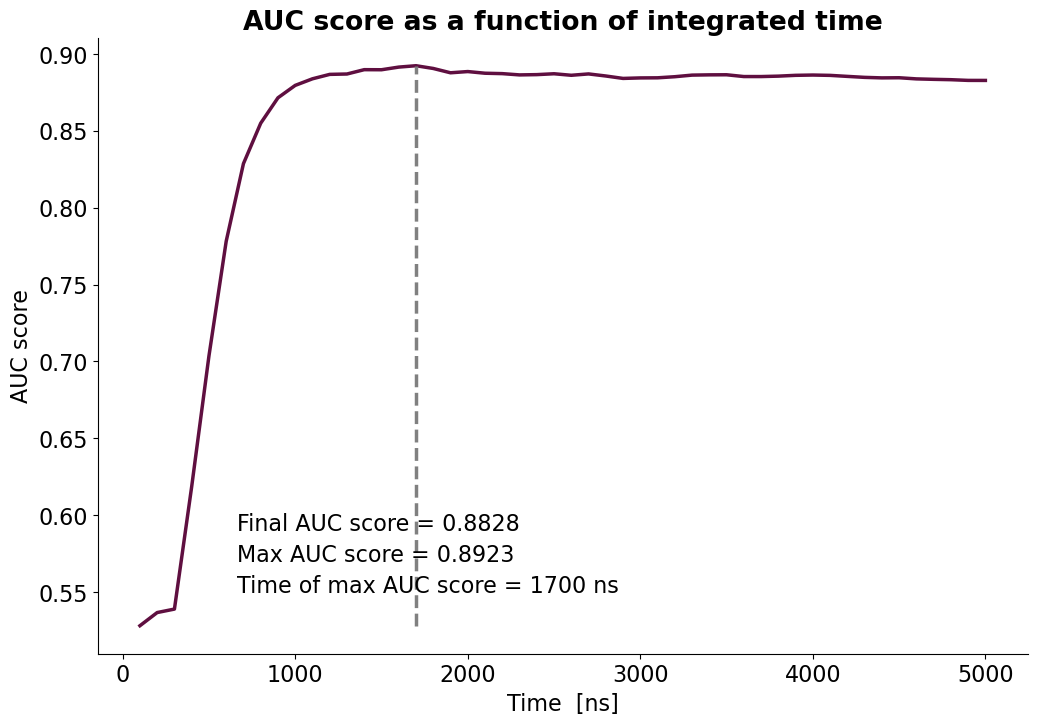

In [12]:
fig, ax = plt.subplots()

ax.set(title = "AUC score as a function of integrated time", xlabel = "Time  [ns]", ylabel = "AUC score")

ax.plot(included_times, auc_scores, label = "AUC score")

# ax.hlines(auc_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[auc_scores.argmax()], auc_scores.min(), auc_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")

ax.text(0.150, 0.20, f"Final AUC score = {auc_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.15, f"Max AUC score = {auc_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.10, f"Time of max AUC score = {included_times[auc_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)

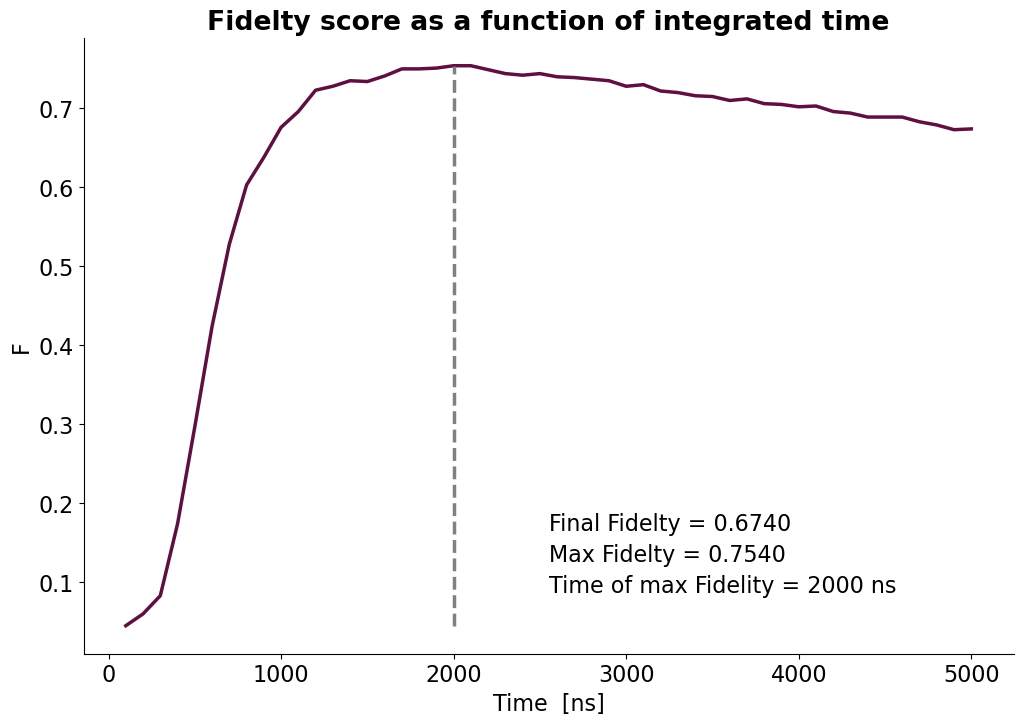

In [13]:
fig, ax = plt.subplots()

ax.set(title = "Fidelty score as a function of integrated time", xlabel = "Time  [ns]", ylabel = "F")

ax.plot(included_times, fidelity_scores, label = "Fidelity")

# ax.hlines(fidelity_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[fidelity_scores.argmax()], fidelity_scores.min(), fidelity_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")

ax.text(0.5, 0.20, f"Final Fidelty = {fidelity_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.5, 0.15, f"Max Fidelty = {fidelity_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.5, 0.10, f"Time of max Fidelity = {included_times[fidelity_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)

fig.savefig(save_path + "/fidelity_over_time_summed.png", dpi = 300)

## Weights by difference in expected IQ 


Weights are made as the difference in the expected trajectory

In [14]:
I_mean_0 = data0.groupby("t").I.agg("mean")
I_mean_1 = data1.groupby("t").I.agg("mean")

I_std_0  = data0.groupby("t").I.agg("std")
I_std_1  = data1.groupby("t").I.agg("std")

weights_I = (I_mean_1 - I_mean_0) / (I_std_0 ** 2 + I_std_1 ** 2)

# repeat for Q 
Q_mean_0 = data0.groupby("t").Q.agg("mean")
Q_mean_1 = data1.groupby("t").Q.agg("mean")

Q_std_0  = data0.groupby("t").Q.agg("std")
Q_std_1  = data1.groupby("t").Q.agg("std")

weights_Q = (Q_mean_1 - Q_mean_0) / (Q_std_0 ** 2 + Q_std_1 ** 2)

In [15]:
weighted_data = data.groupby("trajectory").apply(lambda x: x.assign(I = x.I * weights_I[x.t].values, Q = x.Q * weights_Q[x.t].values))

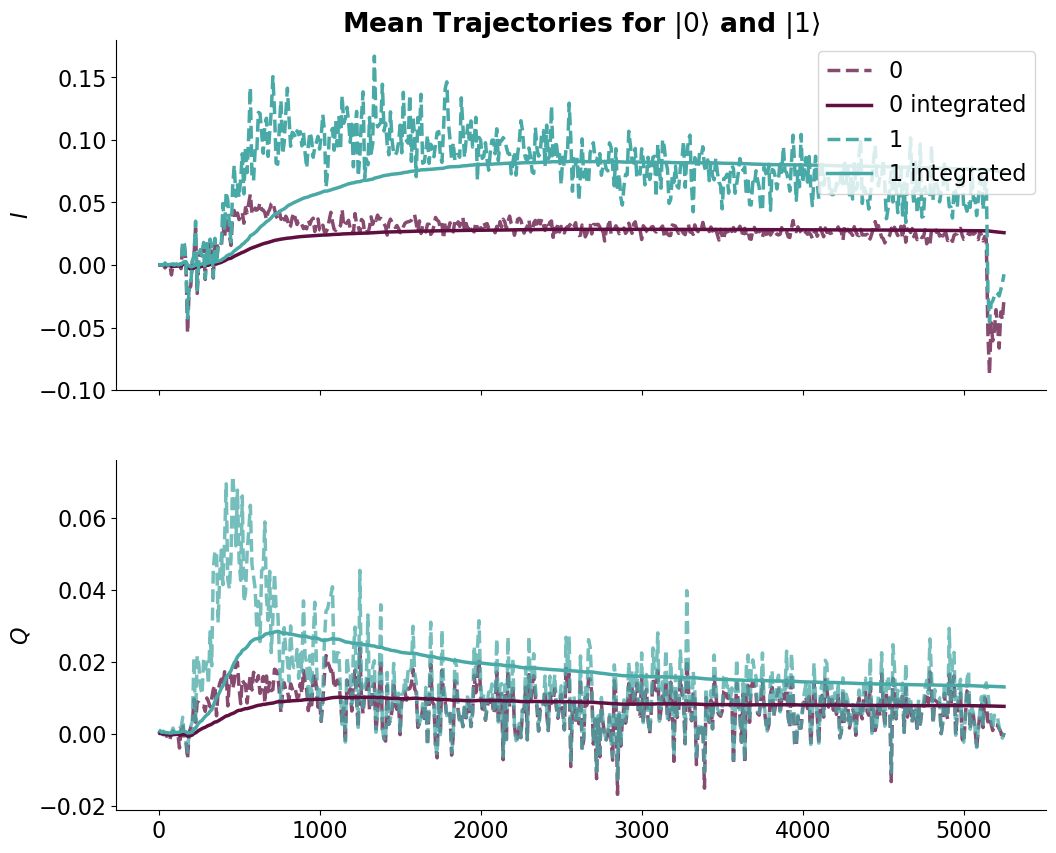

In [16]:
fig, ax = plt.subplots(nrows = 2, figsize = (12, 10), gridspec_kw = {"height_ratios": [1, 1]}, sharex = True)

data0 = weighted_data[weighted_data.initial_state == 0]
data1 = weighted_data[weighted_data.initial_state == 1]

I_mean_0 = data0.groupby("t").I.agg("mean")
I_mean_1 = data1.groupby("t").I.agg("mean")

I_mean_0_integrated = I_mean_0.cumsum() / I_mean_0.index * dt 
I_mean_1_integrated = I_mean_1.cumsum() / I_mean_1.index * dt

I_std_0  = data0.groupby("t").I.agg("std")
I_std_1  = data1.groupby("t").I.agg("std")

Q_mean_0 = data0.groupby("t").Q.agg("mean")
Q_mean_1 = data1.groupby("t").Q.agg("mean")

Q_mean_0_integrated = Q_mean_0.cumsum() / Q_mean_0.index * dt 
Q_mean_1_integrated = Q_mean_1.cumsum() / Q_mean_1.index * dt

Q_std_0  = data0.groupby("t").Q.agg("std")
Q_std_1  = data1.groupby("t").Q.agg("std")

ax[0].set_title(r"Mean Trajectories for $|0\rangle$ and $|1\rangle$")
ax[0].plot(I_mean_0, "--", alpha = 0.75, label = "0")
ax[0].plot(I_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")

ax[0].plot(I_mean_1, "--", alpha = 1, label = "1")
ax[0].plot(I_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[0].set_ylabel(r"$I$")


ax[1].plot(Q_mean_0, "--", alpha = .75, label = "0", color = "C0")
ax[1].plot(Q_mean_1, "--", alpha = .75, label = "1", color = "C1")

ax[1].plot(Q_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")
ax[1].plot(Q_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[1].set_ylabel(r"$Q$")

ax[0].legend(loc = "upper right")


In [17]:
included_times = np.arange(100, 5100, 100)
auc_scores     = []
fidelity_scores = []

for time in tqdm(included_times):
    Q_val = weighted_data.groupby("trajectory").apply(lambda x: x.I[x.t < time].mean())
    I_val = weighted_data.groupby("trajectory").apply(lambda x: x.Q[x.t < time].mean())

    lda = LDA()
    transformed = lda.fit_transform(np.array([Q_val, I_val]).T, summed.initial_state)

    auc = roc_auc_score(summed.initial_state, transformed)
    auc_scores.append(auc)

    confusion = confusion_matrix(summed.initial_state, transformed > 0, normalize = "true")
    fidelity_scores.append(1 - (confusion[0, 1] + confusion[1, 0]))

auc_scores = np.array(auc_scores)
fidelity_scores = np.array(fidelity_scores)


100%|██████████| 50/50 [01:00<00:00,  1.20s/it]


Text(0.15, 0.1, 'Time of max AUC score = 5000 ns')

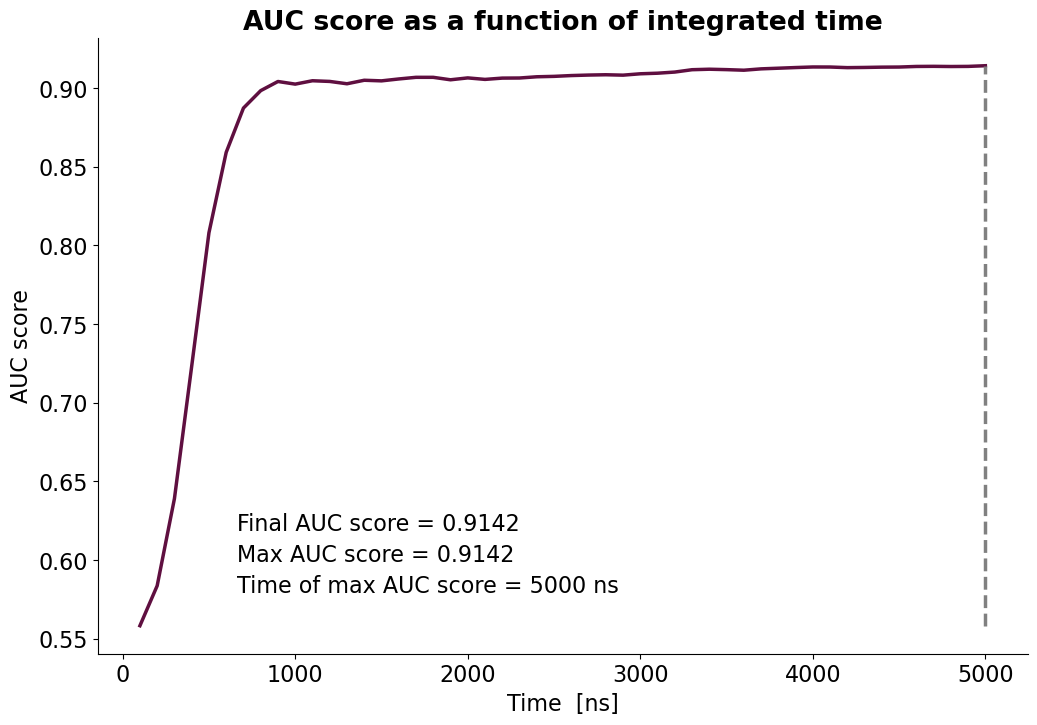

In [18]:
fig, ax = plt.subplots()

ax.set(title = "AUC score as a function of integrated time", xlabel = "Time  [ns]", ylabel = "AUC score")

ax.plot(included_times, auc_scores, label = "AUC score")

# ax.hlines(auc_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[auc_scores.argmax()], auc_scores.min(), auc_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")


ax.text(0.150, 0.20, f"Final AUC score = {auc_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.15, f"Max AUC score = {auc_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.10, f"Time of max AUC score = {included_times[auc_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)

Text(0.15, 0.1, 'Time of max Fidelity = 1700 ns')

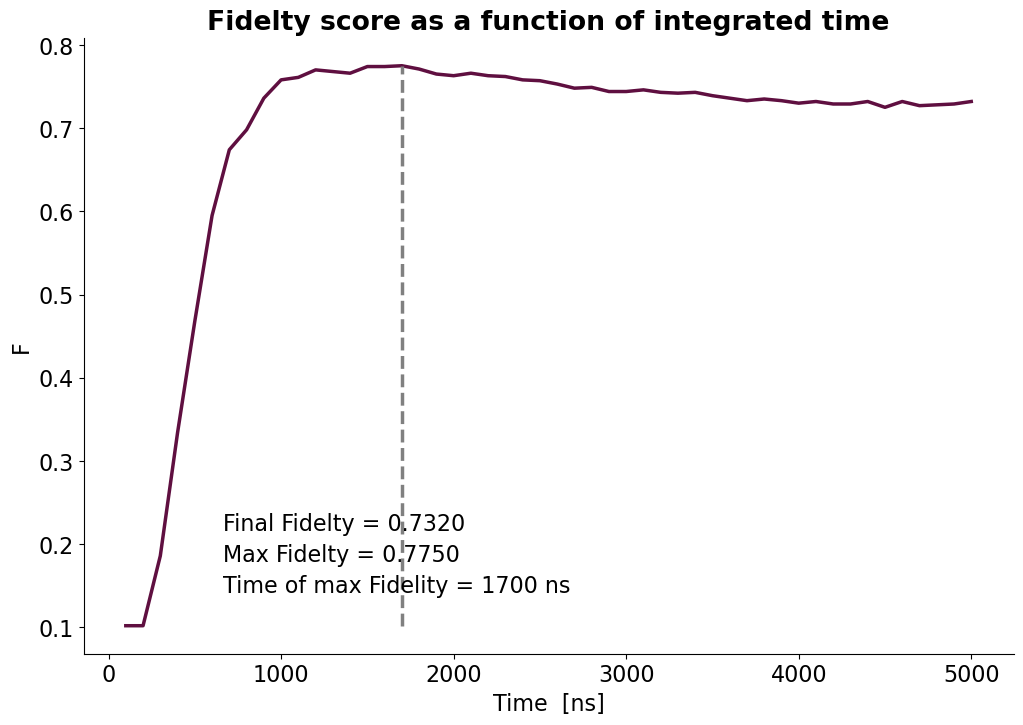

In [19]:
fig, ax = plt.subplots()

ax.set(title = "Fidelty score as a function of integrated time", xlabel = "Time  [ns]", ylabel = "F")

ax.plot(included_times, fidelity_scores, label = "Fidelity")

# ax.hlines(fidelity_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[fidelity_scores.argmax()], fidelity_scores.min(), fidelity_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")

ax.text(0.150, 0.20, f"Final Fidelty = {fidelity_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.15, f"Max Fidelty = {fidelity_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.10, f"Time of max Fidelity = {included_times[fidelity_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)

# Treating like a Fit

All points have a normal distribution around the expected trajectory with uncertainty $\sigma = 1 / \sqrt{\eta}$ where $\eta$ for this simulation is $0.75$. We can calculate the log-likelihood as a chi-square between the expected trajectory and the actual trajectory.

In [20]:
from sklearn.model_selection import train_test_split

traj_train, traj_test = train_test_split(data.trajectory.unique(), test_size = 0.2, random_state = 42)

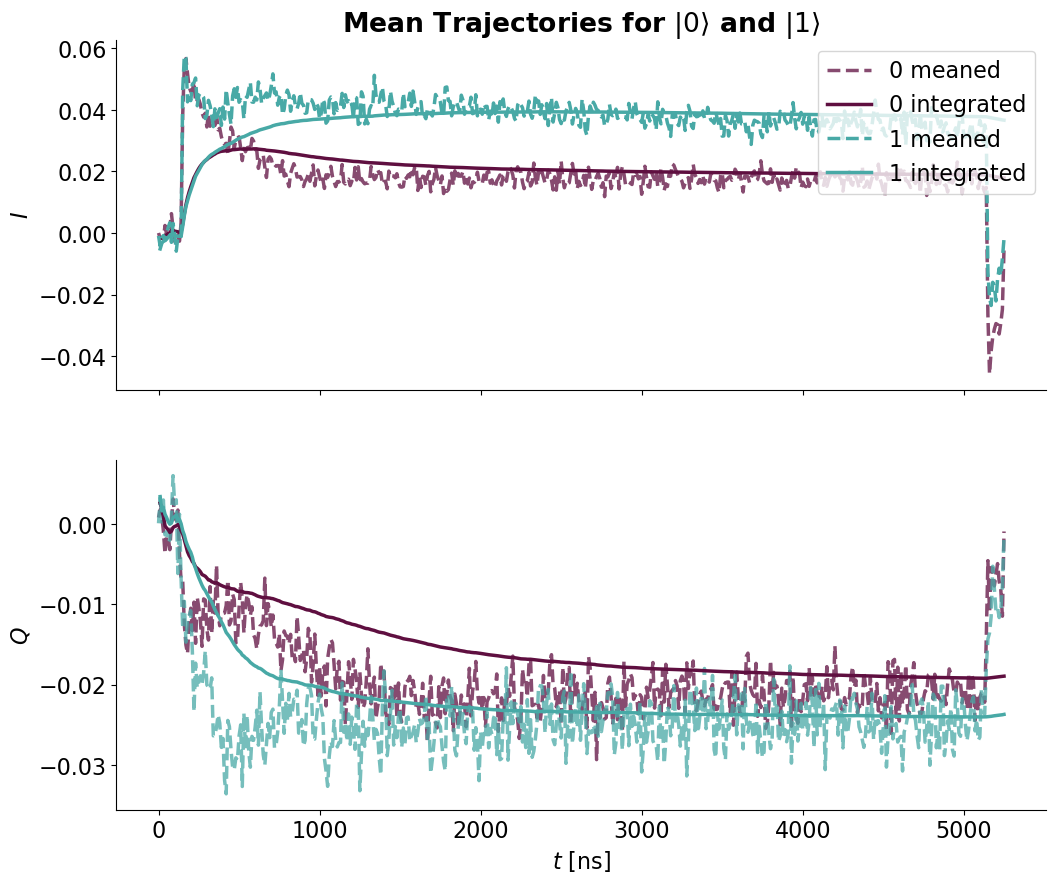

In [21]:
fig, ax = plt.subplots(nrows = 2, figsize = (12, 10), gridspec_kw = {"height_ratios": [1, 1]}, sharex = True)

data0 = data[data.trajectory.isin(traj_train) & data.initial_state == 0]
data1 = data[data.trajectory.isin(traj_train) & data.initial_state == 1]

I_mean_0 = data0.groupby("t").I.agg("mean")
I_mean_1 = data1.groupby("t").I.agg("mean")

I_mean_0_integrated = I_mean_0.cumsum() / I_mean_0.index * dt 
I_mean_1_integrated = I_mean_1.cumsum() / I_mean_1.index * dt

I_std_0  = data0.groupby("t").I.agg("std")
I_std_1  = data1.groupby("t").I.agg("std")

Q_mean_0 = data0.groupby("t").Q.agg("mean")
Q_mean_1 = data1.groupby("t").Q.agg("mean")

Q_mean_0_integrated = Q_mean_0.cumsum() / Q_mean_0.index * dt 
Q_mean_1_integrated = Q_mean_1.cumsum() / Q_mean_1.index * dt

Q_std_0  = data0.groupby("t").Q.agg("std")
Q_std_1  = data1.groupby("t").Q.agg("std")

ax[0].set_title(r"Mean Trajectories for $|0\rangle$ and $|1\rangle$")
ax[0].plot(I_mean_0, "--", alpha = 0.75, label = "0 meaned")
ax[0].plot(I_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")

ax[0].plot(I_mean_1, "--", alpha = 1, label = "1 meaned")
ax[0].plot(I_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[0].set_ylabel(r"$I$")


ax[1].plot(Q_mean_0, "--", alpha = .75, label = "0", color = "C0")
ax[1].plot(Q_mean_1, "--", alpha = .75, label = "1", color = "C1")

ax[1].plot(Q_mean_0_integrated.loc[5:], color = "C0", alpha = 1, label = "0 integrated")
ax[1].plot(Q_mean_1_integrated.loc[5:], color = "C1", alpha = 1, label = "1 integrated")

ax[1].set_ylabel(r"$Q$")

ax[0].legend(loc = "upper right")

ax[1].set_xlabel(r"$t$ [ns]")

fig.savefig(save_path + "/mean_trajectories.png", dpi = 300)


In [22]:
chi2_0 = data[data.trajectory.isin(traj_test)].groupby("trajectory").apply(lambda x: x.assign(I = x.I - I_mean_0[x.t].values, Q = x.Q - Q_mean_0[x.t].values))
chi2_1 = data[data.trajectory.isin(traj_test)].groupby("trajectory").apply(lambda x: x.assign(I = x.I - I_mean_1[x.t].values, Q = x.Q - Q_mean_1[x.t].values))


In [23]:
chi2_0.describe()

,trajectory,initial_state,I,Q,t
count,210400.000000,210400.000000,210400.000000,210400.000000,210400.000000
mean,1011.992500,0.502500,0.007345,-0.001657,2625.000000
std,590.447355,0.499995,0.076074,0.073177,1518.432072
min,23.000000,0.000000,-0.337041,-0.358952,0.000000
25%,481.500000,0.000000,-0.042212,-0.048893,1310.000000
50%,1015.500000,1.000000,0.004341,0.000768,2625.000000
75%,1552.000000,1.000000,0.057133,0.045890,3940.000000
max,1990.000000,1.000000,0.373314,0.314076,5250.000000


In [24]:
chi2_0.I = chi2_0.I ** 2 #/ I_std_0[chi2_0.t].values ** 2
chi2_1.I = chi2_1.I ** 2 #/ I_std_1[chi2_1.t].values ** 2

chi2_0.Q = chi2_0.Q ** 2 #/ Q_std_0[chi2_0.t].values ** 2
chi2_1.Q = chi2_1.Q ** 2 #/ Q_std_1[chi2_1.t].values ** 2

In [25]:
chi2_0.describe()

,trajectory,initial_state,I,Q,t
count,210400.000000,210400.000000,2.104000e+05,2.104000e+05,210400.000000
mean,1011.992500,0.502500,5.841152e-03,5.357626e-03,2625.000000
std,590.447355,0.499995,8.579892e-03,7.917448e-03,1518.432072
min,23.000000,0.000000,7.412977e-15,5.598120e-14,0.000000
25%,481.500000,0.000000,5.233190e-04,4.796252e-04,1310.000000
50%,1015.500000,1.000000,2.435083e-03,2.238600e-03,2625.000000
75%,1552.000000,1.000000,7.594029e-03,6.929404e-03,3940.000000
max,1990.000000,1.000000,1.393631e-01,1.288463e-01,5250.000000


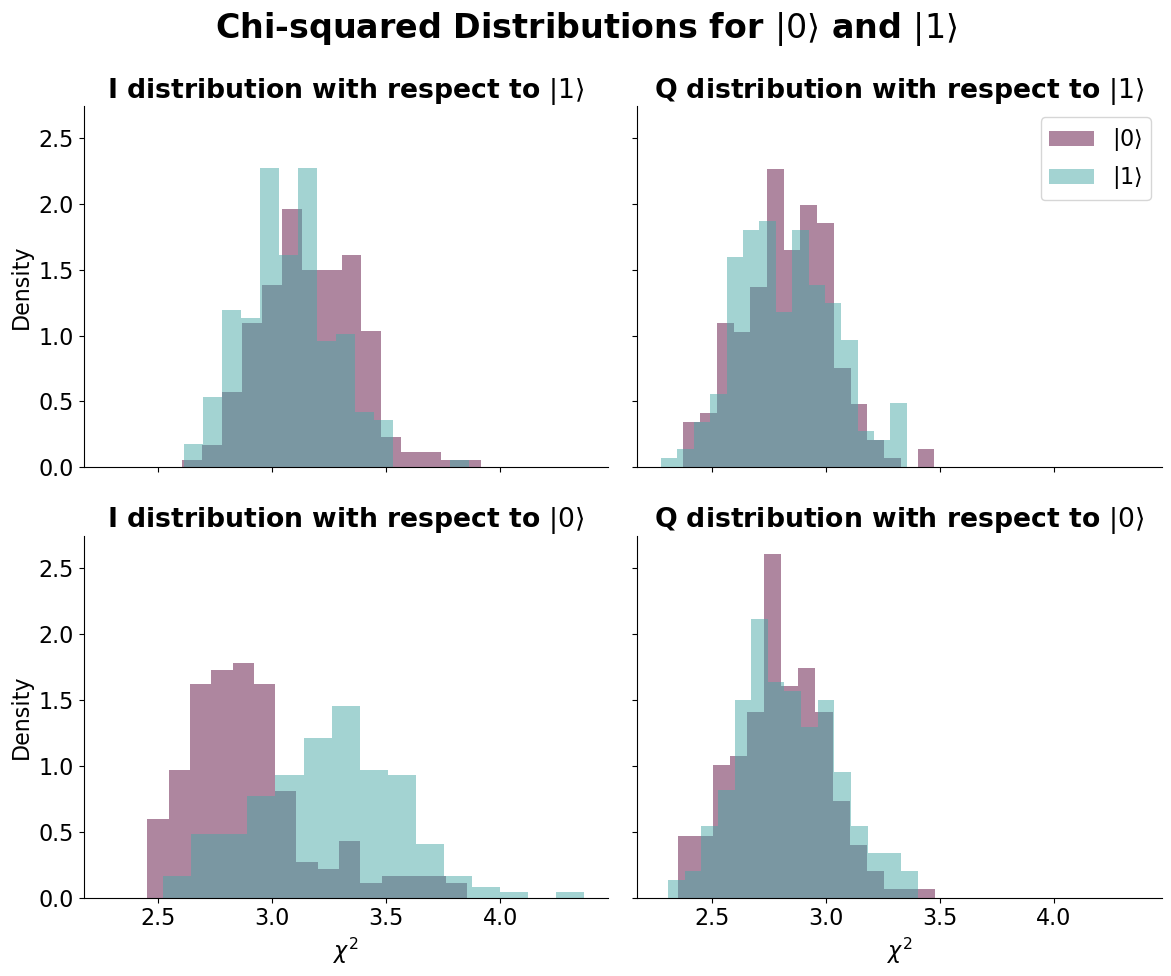

In [26]:
fig, ax = plt.subplots(ncols = 2, nrows = 2, sharex = True, sharey = True, figsize = (12, 10))

fig.suptitle(r"Chi-squared Distributions for $|0\rangle$ and $|1\rangle$", fontsize = 24, fontweight = "bold")

ax[0, 0].hist(chi2_1[chi2_1["initial_state"] == 0].groupby("trajectory").I.agg("sum"), bins = 15, density = True, alpha = 0.5)
ax[0, 0].hist(chi2_1[chi2_1["initial_state"] == 1].groupby("trajectory").I.agg("sum"), bins = 15, density = True, alpha = 0.5)

ax[0, 0].set(
    title = r"I distribution with respect to $|1\rangle$",
    ylabel = "Density"
)

ax[0, 1].hist(chi2_1[chi2_1["initial_state"] == 0].groupby("trajectory").Q.agg("sum"), bins = 15, density = True, alpha = 0.5, label = r"$|0\rangle$")
ax[0, 1].hist(chi2_1[chi2_1["initial_state"] == 1].groupby("trajectory").Q.agg("sum"), bins = 15, density = True, alpha = 0.5, label = r"$|1\rangle$")

ax[0, 1].set(
    title = r"Q distribution with respect to $|1\rangle$",
)

ax[1, 0].hist(chi2_0[chi2_0["initial_state"] == 0].groupby("trajectory").I.agg("sum"), bins = 15, density = True, alpha = 0.5)
ax[1, 0].hist(chi2_0[chi2_0["initial_state"] == 1].groupby("trajectory").I.agg("sum"), bins = 15, density = True, alpha = 0.5)

ax[1, 0].set(
    title = r"I distribution with respect to $|0\rangle$",
    ylabel = "Density",
    xlabel = r"$\chi^2$"
)

ax[1, 1].hist(chi2_0[chi2_0["initial_state"] == 0].groupby("trajectory").Q.agg("sum"), bins = 15, density = True, alpha = 0.5)
ax[1, 1].hist(chi2_0[chi2_0["initial_state"] == 1].groupby("trajectory").Q.agg("sum"), bins = 15, density = True, alpha = 0.5);

ax[1, 1].set(
    title = r"Q distribution with respect to $|0\rangle$",
    xlabel = r"$\chi^2$"
)


ax[0, 1].legend()
fig.tight_layout()

fig.savefig(save_path + "/chi2_distributions.png", dpi = 300)

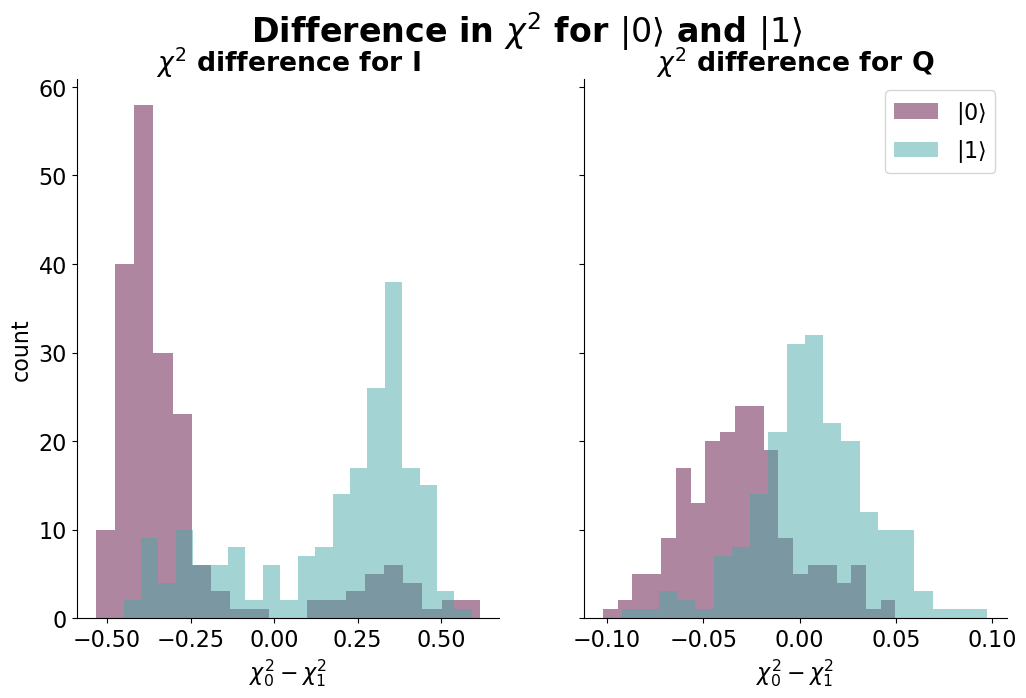

In [27]:
# Perform plots for difference between chi2 for 0 and 1
fig, ax = plt.subplots(ncols = 2, sharey = True, figsize = (12, 7))

fig.suptitle(r"Difference in $\chi^2$ for $|0\rangle$ and $|1\rangle$", fontsize = 24, fontweight = "bold")

ax[0].set(
    title = r"$\chi^2$ difference for I",
    ylabel = "count",
    xlabel = r"$\chi_0^2 - \chi_1^2$"
)

ax[1].set(
    title = r"$\chi^2$ difference for Q",
    xlabel = r"$\chi_0^2 - \chi_1^2$"
)

chi2_I_0 =  (chi2_0[chi2_0["initial_state"] == 0].groupby("trajectory").I.agg("sum")) - (chi2_1[chi2_1["initial_state"] == 0].groupby("trajectory").I.agg("sum"))
chi2_I_1 =  (chi2_0[chi2_0["initial_state"] == 1].groupby("trajectory").I.agg("sum")) - (chi2_1[chi2_1["initial_state"] == 1].groupby("trajectory").I.agg("sum"))

chi2_Q_0 =  (chi2_0[chi2_0["initial_state"] == 0].groupby("trajectory").Q.agg("sum")) - (chi2_1[chi2_1["initial_state"] == 0].groupby("trajectory").Q.agg("sum"))
chi2_Q_1 =  (chi2_0[chi2_0["initial_state"] == 1].groupby("trajectory").Q.agg("sum")) - (chi2_1[chi2_1["initial_state"] == 1].groupby("trajectory").Q.agg("sum"))

#
ax[0].hist(chi2_I_0, bins = 20, alpha = 0.5)
ax[0].hist(chi2_I_1, bins = 20, alpha = 0.5)

ax[1].hist(chi2_Q_0, bins = 20, alpha = 0.5, label = r"$|0\rangle$")
ax[1].hist(chi2_Q_1, bins = 20, alpha = 0.5, label = r"$|1\rangle$")

ax[1].legend()


fig.savefig(save_path + "/chi2_differences.png", dpi = 300)

In [28]:
chi2_score_0_I = chi2_0.groupby("trajectory").I.agg("sum")
chi2_score_0_Q = chi2_0.groupby("trajectory").Q.agg("sum")
chi2_score_1_I = chi2_1.groupby("trajectory").I.agg("sum")
chi2_score_1_Q = chi2_1.groupby("trajectory").Q.agg("sum")

In [29]:
labels = chi2_0.groupby("trajectory").initial_state.first()

roc_auc_score(labels, chi2_score_0_I - chi2_score_1_I), roc_auc_score(labels, chi2_score_0_Q - chi2_score_1_Q)

(0.8731468286707167, 0.8257206430160755)

In [30]:
included_times = np.arange(100, 5100, 100)
auc_scores     = []
fidelity_scores = []

for time in tqdm(included_times):

    chi2_score_0_I = chi2_0[chi2_0.t <= time].groupby("trajectory").I.agg("sum")
    chi2_score_0_Q = chi2_0[chi2_0.t <= time].groupby("trajectory").Q.agg("sum")
    chi2_score_1_I = chi2_1[chi2_1.t <= time].groupby("trajectory").I.agg("sum")
    chi2_score_1_Q = chi2_1[chi2_1.t <= time].groupby("trajectory").Q.agg("sum")

    Q_val = (chi2_score_0_Q - chi2_score_1_Q)
    I_val = (chi2_score_0_I - chi2_score_1_I) 
    
    lda = LDA()
    transformed = lda.fit_transform(np.array([Q_val, I_val]).T, labels)

    auc = roc_auc_score(labels, transformed)
    auc_scores.append(auc)

    confusion = confusion_matrix(labels, transformed > 0, normalize = "true" )
    fidelity_scores.append(1 - (confusion[0, 1] + confusion[1, 0]))

auc_scores = np.array(auc_scores)
fidelity_scores = np.array(fidelity_scores)


100%|██████████| 50/50 [00:02<00:00, 19.28it/s]


<AxesSubplot:>

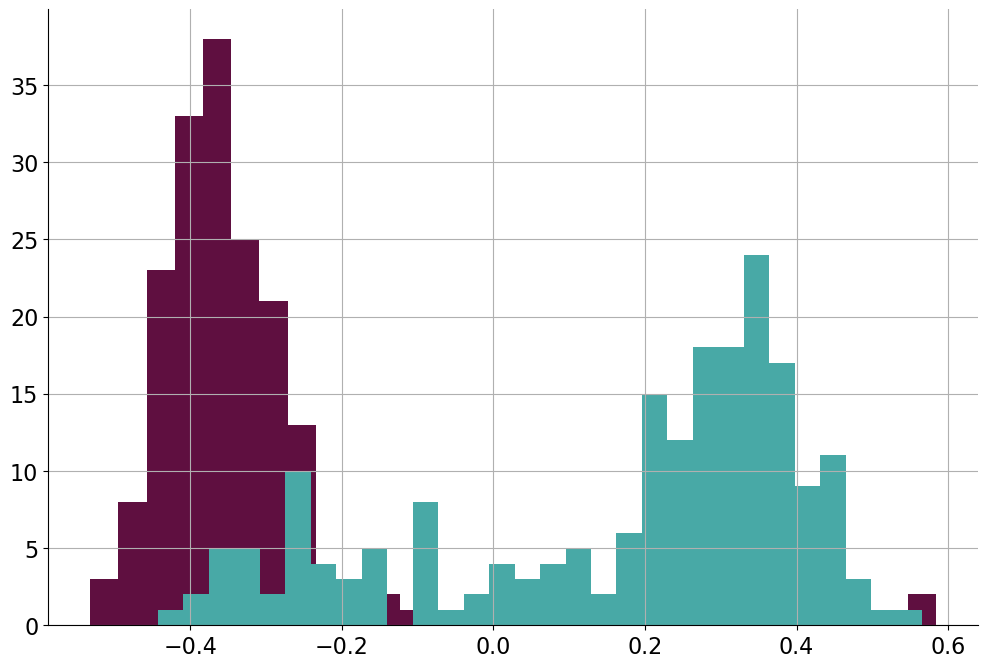

In [31]:
I_val[labels == 0].hist(bins = 30)
I_val[labels == 1].hist(bins = 30)

Text(0.15, 0.1, 'Time of max AUC score = 1100 ns')

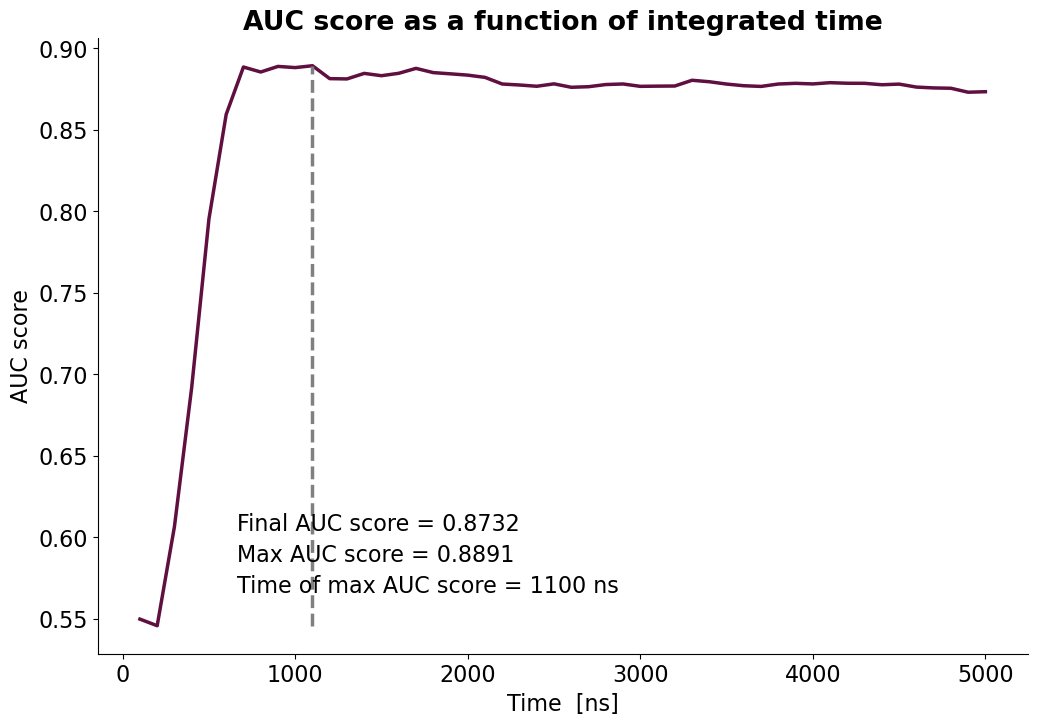

In [32]:
fig, ax = plt.subplots()

ax.set(title = "AUC score as a function of integrated time", xlabel = "Time  [ns]", ylabel = "AUC score")

ax.plot(included_times, auc_scores, label = "AUC score")

# ax.hlines(auc_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[auc_scores.argmax()], auc_scores.min(), auc_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")

ax.text(0.150, 0.20, f"Final AUC score = {auc_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.15, f"Max AUC score = {auc_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.150, 0.10, f"Time of max AUC score = {included_times[auc_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)



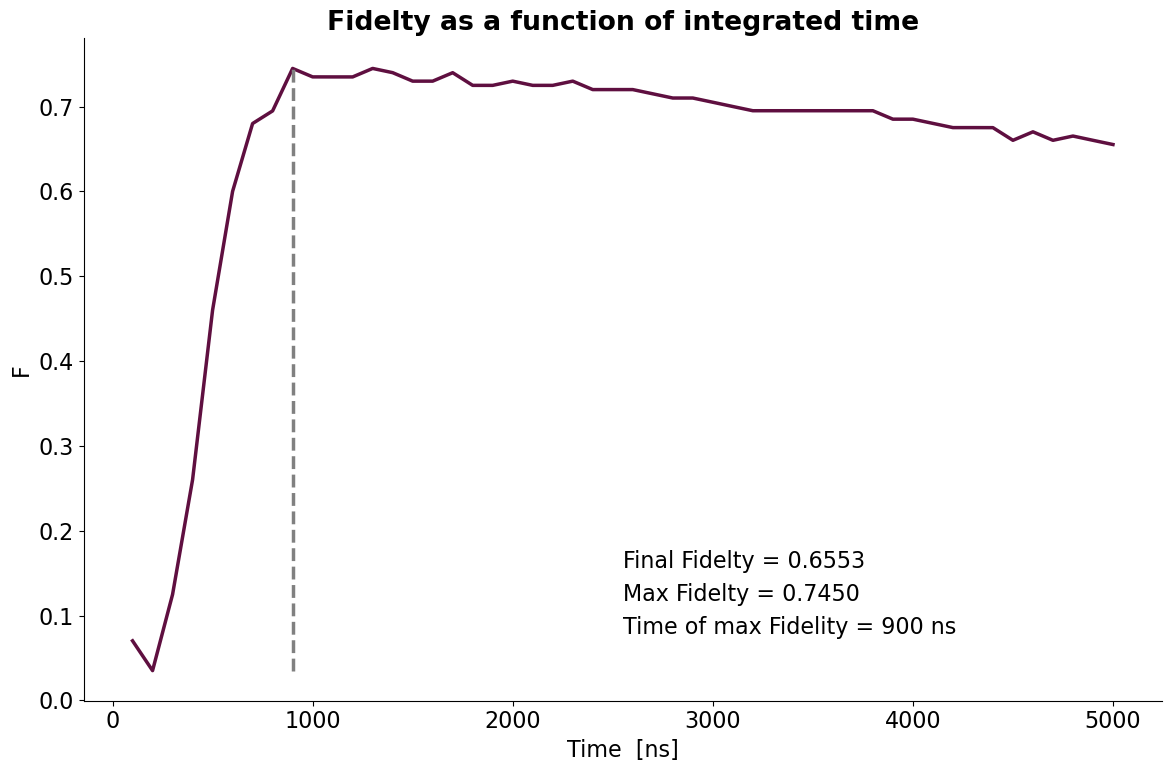

In [33]:
fig, ax = plt.subplots()

ax.set(title = "Fidelty as a function of integrated time", xlabel = "Time  [ns]", ylabel = "F")

ax.plot(included_times, fidelity_scores, label = "Fidelity")

# ax.hlines(fidelity_scores.max(), included_times.min(), included_times.max(), label = "Max AUC score", color = "gray", ls = "--")
ax.vlines(included_times[fidelity_scores.argmax()], fidelity_scores.min(), fidelity_scores.max(), label = "Time of max AUC score", color = "gray", ls = "--")

ax.text(0.50, 0.20, f"Final Fidelty = {fidelity_scores[-1]:.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.50, 0.15, f"Max Fidelty = {fidelity_scores.max():.4f}", transform = ax.transAxes, fontsize = 16)
ax.text(0.50, 0.10, f"Time of max Fidelity = {included_times[fidelity_scores.argmax()]} ns", transform = ax.transAxes, fontsize = 16)

fig.tight_layout()
fig.savefig(save_path + "/fidelity_vs_time_chi2.png", dpi = 300)